In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras import layers
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
tf.keras.backend.clear_session()  # For easy reset of notebook state.


In [2]:
def write_tsv(array, name):
    if len(array.shape) == 2:
        l, w = array.shape
    else:
        array = array.reshape(-1,1)
        l, w = array.shape
    
    with open(name,'w') as f:
        for i in range(l):
            for j in range(w):
                f.write(str(array[i,j]))
                if j != w-1:
                    f.write('\t')
            f.write('\n')
            
            

In [85]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(layers.Layer):
    def __init__(self,
               latent_dim=32,
               intermediate_dim=64,
               name='encoder',
               **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        #self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        #x = self.dense_proj(inputs)
        z_mean = self.dense_mean(inputs)
        z_log_var = self.dense_log_var(inputs)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


class Decoder(layers.Layer):
    def __init__(self,
               original_dim,
               intermediate_dim=64,
               name='decoder',
               **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        #self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
        self.dense_output = layers.Dense(original_dim, activation=None)

    def call(self, inputs):
        #x = self.dense_proj(inputs)
        return self.dense_output(inputs)


class VariationalAutoEncoder(tf.keras.Model):
    def __init__(self,
               original_dim,
               intermediate_dim=64,
               latent_dim=32,
               name='vae',
               **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim,
                               intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        # self._set_inputs(inputs)
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean( z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1,axis=-1)
        self.add_loss(kl_loss)
        return reconstructed
    
    def get_decoded(self, inputs):
        return self.decoder(inputs)
        
    def get_latent(self, inputs):
        return  self.encoder(inputs)


In [69]:
all_data= np.load('traj.npy').astype(np.float32)
np.random.shuffle(all_data)

In [70]:
train_size = int(all_data.shape[0] * 0.98)
train_data = all_data[:train_size]
test_data = all_data[train_size:]

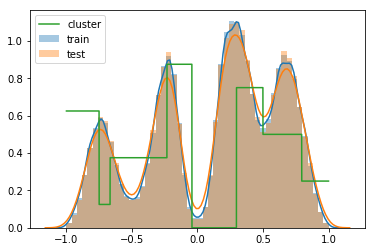

In [118]:
sns.distplot(train_data,label='train')
sns.distplot(test_data,label='test')
plt.plot(np.linspace(-1,1,len(clusters)),clusters[inds]/8,label='cluster')
plt.legend()

In [106]:
gm = GaussianMixture(n_components=8)
clusters = gm.fit_predict(train_data)
inds = train_data.argsort(axis=0).reshape(-1)

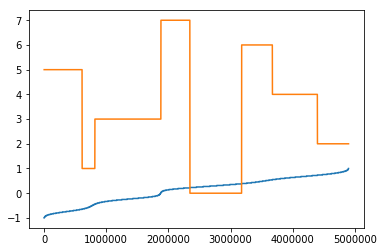

In [107]:
train_data.sort()
plt.plot(train_data[inds])
plt.plot(clusters[inds])

In [74]:
np.random.shuffle(train_data)
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
test_dataset = tf.data.Dataset.from_tensor_slices(test_data)

In [75]:
train_dataset = train_dataset.shuffle(10240).batch(2048)
test_dataset = test_dataset.batch(10000)

In [155]:
(x_train, train_labels), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)
original_dim = 784

vae = VariationalAutoEncoder(original_dim, 128, 2)  #, input_shape=(784,)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_metric = tf.keras.metrics.Mean()

In [150]:
original_dim = 1

vae = VariationalAutoEncoder(original_dim, 16, 2)  #, input_shape=(784,)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_metric = tf.keras.metrics.Mean()


In [156]:
# Iterate over epochs.
for epoch in range(20):
    print('Start of epoch %d' % (epoch,))
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
      # !!! uncomment the following two lines to use workaround and skip !!!
      # if step == 0 and epoch == 0:
      #   vae._set_inputs(x_batch_train)
            reconstructed = vae(x_batch_train)
      # Compute reconstruction loss
            recon_loss = tf.reduce_mean((x_batch_train-reconstructed)**2,axis=-1)
            kl_loss = vae.losses[-1]
            loss = kl_loss * 0.01 + recon_loss # Add KLD regularization loss
        print(tf.reduce_mean(recon_loss).numpy())
        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        loss_metric(loss)

        if step % 1000 == 0:
            print('step %s: mean loss = %s' % (step, loss_metric.result()))

Start of epoch 0
0.11506382
step 0: mean loss = tf.Tensor(0.11634304, shape=(), dtype=float32)
0.116151445
0.11230907
0.10163914
0.12452771
0.12027072
0.111307666
0.10951549
0.11247418
0.11004942
0.10748338
0.106160544
0.113484174
0.104052015
0.11098895
0.12004815
0.11417458
0.109661296
0.1014044
0.10994262
0.116610155
0.10850901
0.10487646
0.10250701
0.107609436
0.10722242
0.11460492
0.107325815
0.107149616
0.10166311
0.105735905
0.10202056
0.103855066
0.10192589
0.09659824
0.105164334
0.09426146
0.09802112
0.09498279
0.08931355
0.096432984
0.099748075
0.09195939
0.089734405
0.089783676
0.08856702
0.09716902
0.095209554
0.09333314
0.09205207
0.08970146
0.08614345
0.08871417
0.087068565
0.089457676
0.08793633
0.07932224
0.09358581
0.08690521
0.08962449
0.084649354
0.08991431
0.078199126
0.084107846
0.083671
0.08417076
0.08397797
0.07984615
0.07933684
0.08567052
0.08059327
0.08155841
0.08252606
0.08201967
0.08315858
0.079513505
0.07631334
0.07863514
0.07745454
0.07960951
0.0805608
0.078

0.063613944
0.061267678
0.0633036
0.066005856
0.06573136
0.067586794
0.06404004
0.05984273
0.06775968
0.06363717
0.061459776
0.06364335
0.0669546
0.06473495
0.061471716
0.059886795
0.06820764
0.06377458
0.062566355
0.067838304
0.06414478
0.06371756
0.06520448
0.0674881
0.066530466
0.06398148
0.063146204
0.062725484
0.06733228
0.07054925
0.0636815
0.062076084
0.06145838
0.06589006
0.0633708
0.06471495
0.063181005
0.06335546
0.06328077
0.068628676
0.059324298
0.064219356
0.059911087
0.062585026
0.06634767
0.06117204
0.06555397
0.06572911
0.064020135
0.06556242
0.059112187
0.06335993
0.0639613
0.05827953
0.061495423
0.0672228
0.06453487
0.0610617
0.062796175
0.06117917
0.06435761
0.06308857
0.06051939
0.059598744
0.061017737
0.06700662
0.06345864
0.06860295
0.06480459
0.0655515
0.061376985
0.06697036
0.062533796
0.065198466
0.060742218
0.060234014
0.06786232
0.0638369
0.061738536
0.061232332
0.061350383
0.05973494
0.061971843
0.06363286
0.060120232
0.06150793
0.064263195
0.06332799
0.0633

KeyboardInterrupt: 

In [119]:
test_clusters = gm.predict(test_data)
prediction = vae(test_data)

In [120]:
r2_score(y_pred=prediction,y_true=test_data)

0.9904389997876455

In [144]:
test_cluster = gm.predict(x_train[:1000])

ValueError: Expected the input data X have 1 features, but got 784 features

In [157]:
_,_,encoded = vae.get_latent(x_train[:1000])

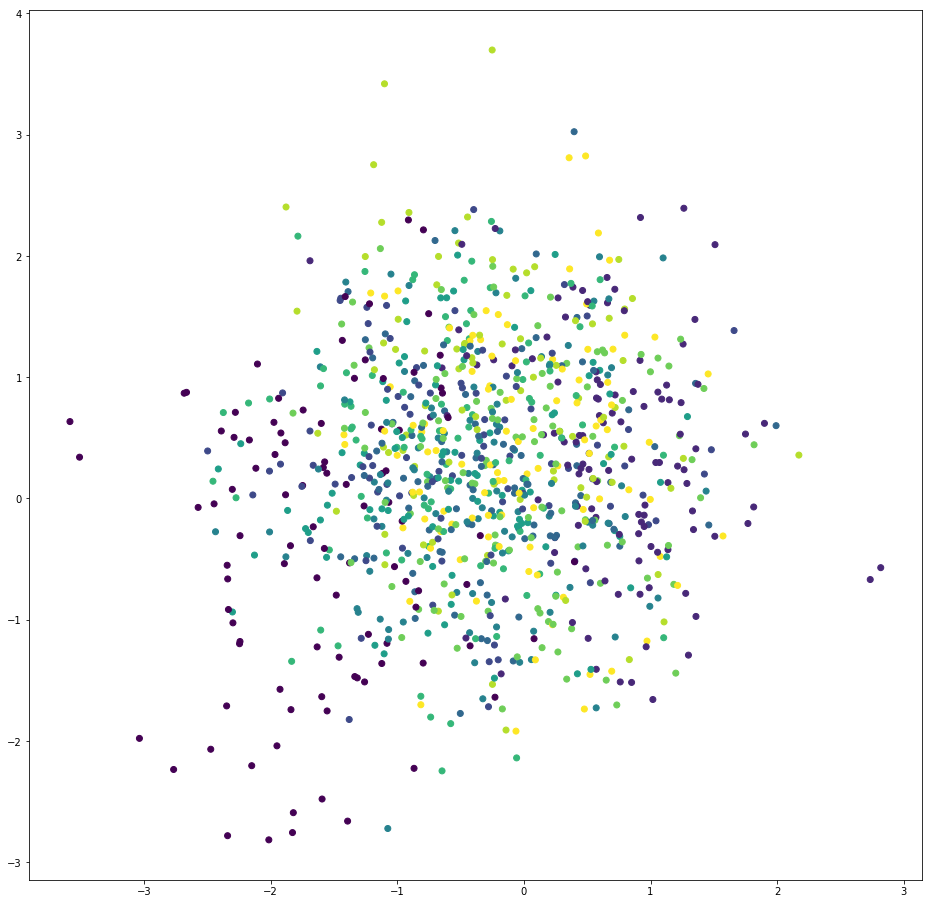

In [158]:
plt.figure(figsize=(16,16))
plt.scatter(encoded[:,0],encoded[:,1],c=train_labels[:1000])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



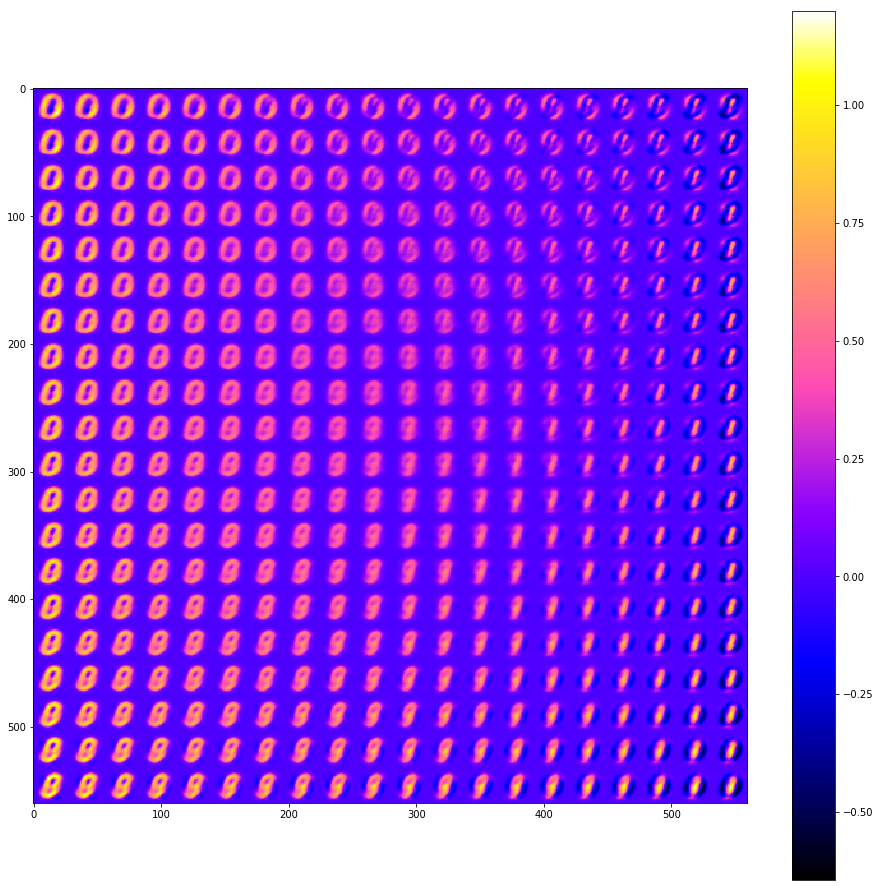

In [159]:
from scipy.stats import norm
batch_size = 1
n = 20
# figure with 20x20 digits
input_size = 28
figure = np.zeros((input_size * n, input_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))*2
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))*2

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        #z_sample = (np.random.rand(1,256)-0.5)*3
        x_decoded = vae.get_decoded(z_sample)
        recon_sample = x_decoded[0].numpy().reshape(input_size, input_size)
        figure[i * input_size: (i + 1) * input_size,
               j * input_size: (j + 1) * input_size] = recon_sample

plt.figure(figsize=(16, 16))
#plt.matshow(figure, cmap='gnuplot2')
plt.imshow(figure, cmap='gnuplot2')
plt.colorbar()
plt.show()  